# DESCRIPTION

Develop ML models for image classification then convert the models into embeddable TF-Lite file format on Android and iOS.

This dataset consists of more than four hundred thousand handwritten names collected through charity projects.

total_all_dataset: 413704

Dataset: [Handwriting Recognition](https://www.kaggle.com/datasets/landlord/handwriting-recognition)

# DATA PREPARATION

## Libraries

In [43]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import preprocess_input

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install kaggle

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/kaggle_API_credentials"

In [5]:
!kaggle datasets download -d landlord/handwriting-recognition

100% 1.26G/1.26G [01:04<00:00, 23.0MB/s]
100% 1.26G/1.26G [01:04<00:00, 20.8MB/s]


In [6]:
!unzip -qq handwriting-recognition.zip -d handwriting

In [7]:
!ls handwriting

test_v2   validation_v2		    written_name_train_v2.csv
train_v2  written_name_test_v2.csv  written_name_validation_v2.csv


In [8]:
base_dir = '/content/handwriting'
TRAINING_DIR = base_dir
VALIDATION_DIR = base_dir

dir_trainv2 = os.path.join(base_dir, 'train_v2/train')
dir_testv2 = os.path.join(base_dir, 'test_v2/test')
dir_validationv2 = os.path.join(base_dir, 'validation_v2/validation')

In [9]:
def count_contents_directory(base_dir):
    total_file = 0
    total_folder = 0

    # Mengecheck seluruh isi direktori
    for root, dirs, files in os.walk(base_dir):
        total_folder += len(dirs)
        total_file += len(files)

    return (total_file, total_folder)

total_all_files, total_all_folders = count_contents_directory(base_dir)
print("total_all_files:", total_all_files)
print("total_all_folders:", total_all_folders)

total_all_files: 413704
total_all_folders: 6


In [10]:
print('Total dir_trainv2:', len(os.listdir(dir_trainv2)))
print('Total dir_testv2:', len(os.listdir(dir_testv2)))
print('Total dir_validationv2:', len(os.listdir(dir_validationv2)))

Total dir_trainv2: 330961
Total dir_testv2: 41370
Total dir_validationv2: 41370


# DATA PREPROCESSING

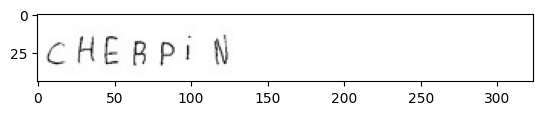

In [11]:
img = image.load_img(dir_testv2 + '/TEST_0005.jpg')
imgplt = plt.imshow(img)

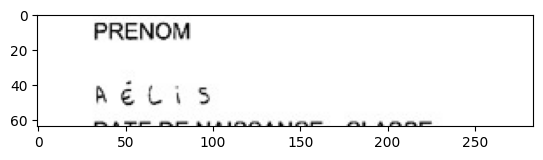

In [12]:
img = image.load_img(dir_testv2 + '/TEST_0020.jpg')
imgplt = plt.imshow(img)

## Image Augmentation

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    preprocessing_function=preprocess_input  # Apply VGG16 preprocessing
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

Found 330961 images belonging to 3 classes.


In [24]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = test_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150, 150),
    class_mode='categorical',
    subset='validation'
)

Found 82740 images belonging to 3 classes.


# MODELING SEQUENTIAL

In [25]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 36, 36, 64)       

## Compiling the model

In [27]:
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Callback

In [28]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, target_accuracy=0.96, consecutive_epochs=3):
        self.target_accuracy = target_accuracy
        self.consecutive_epochs = consecutive_epochs
        self.consecutive_count = 0

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      self.model.stop_training = True
      print('\n\nCallback called --- Done training!')
      print(" Accuracy above 92% ".center(33, '-'), '\n\n')

    if logs.get('val_accuracy') >= self.target_accuracy:
      self.consecutive_count += 1
      if self.consecutive_count >= self.consecutive_epochs:
        if logs.get('accuracy') >= 0.82 and logs.get('val_accuracy') >= self.target_accuracy:
         self.model.stop_training = True
         print('\n\nCallback called --- Done training!')
         print(" val_accuracy above 96% for 3 consecutive epochs ".center(60, '-'), '\n\n')
    else:
      self.consecutive_count = self.consecutive_count

### Implementing a learning rate scheduler

In [29]:
def lr_scheduler(epoch, lr):
  initial_lr=0.001
  drop=0.5
  epochs_drop=10
  lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
  return lr

In [30]:
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    myCallback()
]

## Training the model

In [31]:
%%time
h = model.fit(
    train_generator,
    steps_per_epoch=1,
    epochs=200,
    validation_data=test_generator,
    validation_steps=1,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/200
1/1 - 6s - loss: 0.9939 - accuracy: 0.5781 - val_loss: 0.9190 - val_accuracy: 0.8438 - lr: 0.0010 - 6s/epoch - 6s/step
Epoch 2/200
1/1 - 2s - loss: 2.4624 - accuracy: 0.8047 - val_loss: 0.5469 - val_accuracy: 0.8750 - lr: 0.0010 - 2s/epoch - 2s/step
Epoch 3/200
1/1 - 1s - loss: 0.6951 - accuracy: 0.8438 - val_loss: 0.9507 - val_accuracy: 0.7812 - lr: 0.0010 - 1s/epoch - 1s/step
Epoch 4/200
1/1 - 1s - loss: 0.7542 - accuracy: 0.8359 - val_loss: 1.0335 - val_accuracy: 0.6250 - lr: 0.0010 - 1s/epoch - 1s/step
Epoch 5/200
1/1 - 1s - loss: 0.9008 - accuracy: 0.7344 - val_loss: 0.9606 - val_accuracy: 0.8438 - lr: 0.0010 - 992ms/epoch - 992ms/step
Epoch 6/200
1/1 - 1s - loss: 0.8737 - accuracy: 0.7109 - val_loss: 0.9294 - val_accuracy: 0.8438 - lr: 0.0010 - 1s/epoch - 1s/step
Epoch 7/200
1/1 - 1s - loss: 0.7990 - accuracy: 0.7734 - val_loss: 0.8643 - val_accuracy: 0.8438 - lr: 0.0010 - 1s/epoch - 1s/step
Epoch 8/200
1/1 - 1s - loss: 0.8135 - accuracy: 0.7266 - val_loss: 0.7478 - v

# DATA VISUALIZATION

## Accuracy Graph

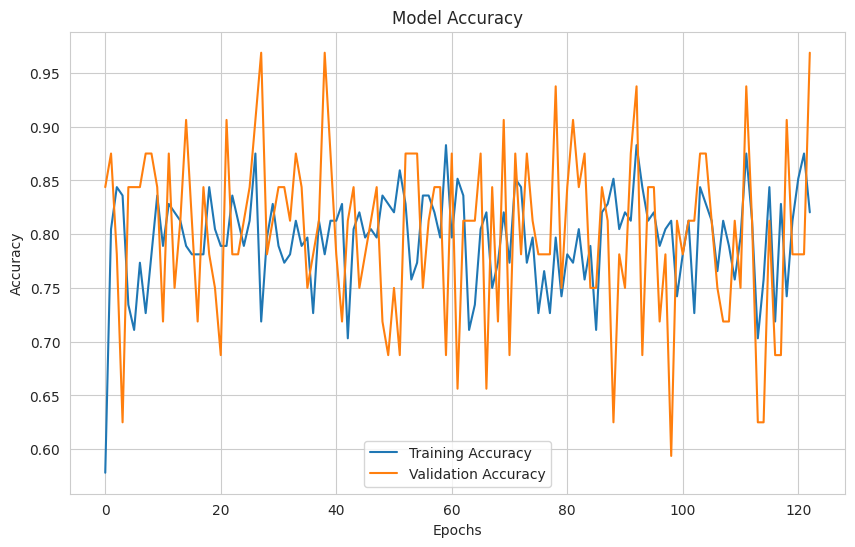

In [32]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss Graph

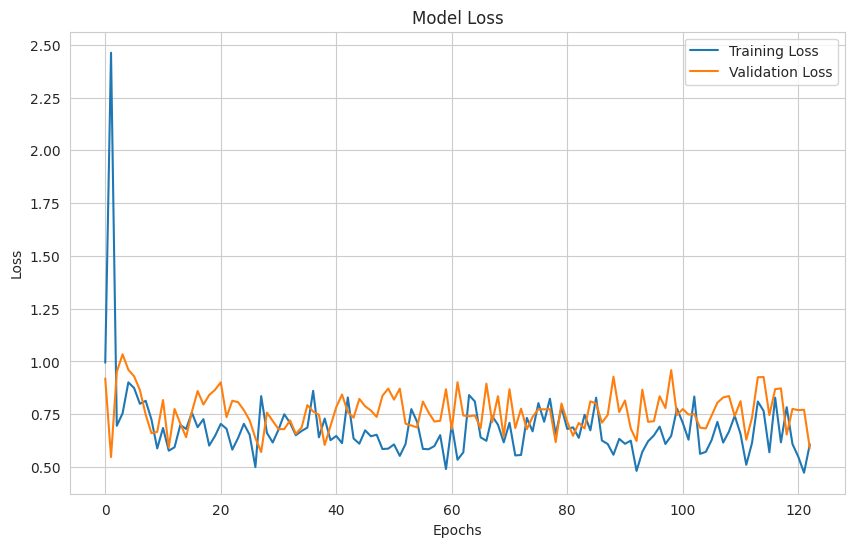

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# FORMAT TF-Lite

In [41]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [42]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [45]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

7983128